In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("Medicalpremium.csv")

In [3]:
df = data.copy()

# Custom transformers

In [4]:
class upsample(BaseEstimator, TransformerMixin):
    def __init__(self, category="NumberOfMajorSurgeries", cls=3, nSamples=100):
        self.category = category
        self.nSamples = nSamples
        self.cls = cls

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        sample = resample(X[X[self.category] == self.cls], n_samples=self.nSamples, replace=True)
        X = pd.concat([X[X[self.category] != self.cls], sample])
        X.reset_index(drop=True, inplace=True)
        return X

In [5]:
class BMI(BaseEstimator, TransformerMixin):
    def __init__(self, bmi=True, bmiCat=True, dropbmi=False):
        self.bmi = bmi
        self.bmiCat = bmiCat
        self.dropbmi = dropbmi

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.bmi:
            X["BMI"] = X["Weight"]/(X["Height"]/100)**2
            X = X.drop(["Weight", "Height"], axis=1)
            
            if self.bmiCat:
                bins = [0, 18.5, 24.9, 29.9, 34.9, 100]
                labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Extreme']
                X["BMI_cat"] = pd.cut(X["BMI"], bins=bins, labels=labels, right=False)
                if self.dropbmi:
                    X = X.drop("BMI", axis=1)
                    return X
                else:
                    #X = X.drop(["Weight", "Height"], axis=1)
                    return X
            else:
                #X = X.drop(["Weight", "Height"], axis=1)
                return X
        else:
            return X

In [6]:
class oneHot(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.encoder = OneHotEncoder(sparse=False, drop='first')

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        onehot_encoded = self.encoder.transform(X[self.columns])
        feature_names = self.encoder.get_feature_names_out()
        result_df = pd.DataFrame(onehot_encoded, columns=feature_names, index=X.index)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

In [7]:
class StdScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        num_cols = [i for i in X.columns if len(np.unique(X[i])) > 5]
        self.columns = num_cols
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        scaled_data = self.scaler.transform(X[self.columns])
        result_df = pd.DataFrame(scaled_data, columns=self.columns, index=X.index)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

# preprocessing

In [8]:
dt = upsample(category= "NumberOfMajorSurgeries", cls=3, nSamples=100).transform(df.copy())

In [9]:
X = dt.drop("PremiumPrice", axis=1)
y = dt.PremiumPrice.copy()

In [10]:
X.shape

(1070, 10)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
pipe = Pipeline([
    ('bmi', BMI(bmiCat=False)),
    #('oneHot', oneHot(columns=["BMI_cat"])),
    ('scaler', StdScaler())
])

In [13]:
X_train = pipe.fit_transform(x_train.copy())
X_test = pipe.fit_transform(x_test.copy())

# Random Forest

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [15]:
forest_reg = RandomForestRegressor(random_state=42)

In [16]:
forest_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [17]:
pred = forest_reg.predict(X_test)

In [18]:
np.sqrt(mean_squared_error(y_test, pred))

3805.3829925023538

[0.00658656 0.0063904  0.08997843 0.03800793 0.00420279 0.02429021
 0.03622052 0.66875377 0.12556939]


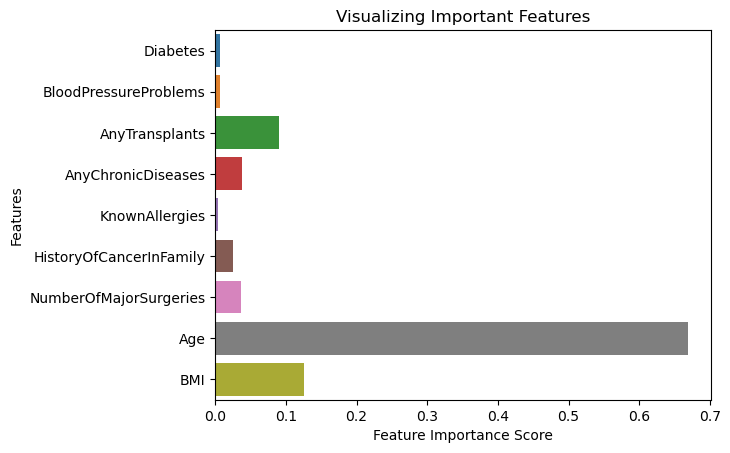

In [19]:
feature_imp1 = forest_reg.feature_importances_
print(feature_imp1)

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

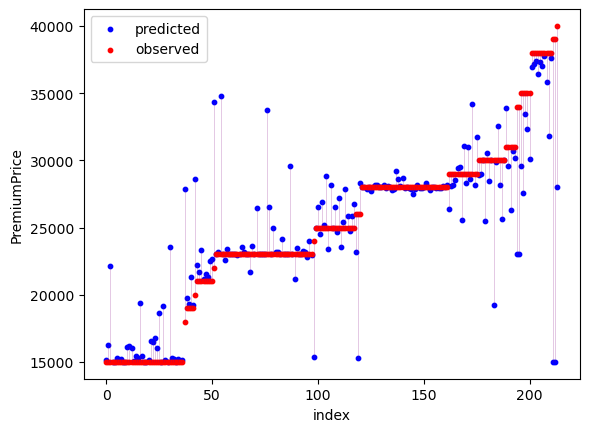

In [20]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='blue', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='red', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

In [21]:
pred = forest_reg.predict(X_train)
np.sqrt(mean_squared_error(y_train, pred))

1054.5698839749389

## cross validation forest

In [22]:
scores = cross_val_score(forest_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)

In [23]:
forest_rmse_scores = np.sqrt(-scores)

In [24]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [25]:
display_scores(forest_rmse_scores)

Scores: [3334.63728372 1826.99079057 1748.0025145  3029.26501179 2255.6203705
 3828.76520869 2865.30811401 2576.08458027 1928.95186413 3850.9632103 ]
Mean: 2724.458894846973
Standard deviation: 748.8083427149965


## hyperparameter forest

### RandomizedGridSearch

In [26]:
forest_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [27]:
from sklearn.model_selection import RandomizedSearchCV

In [28]:
n_estimators = [int(i) for i in np.linspace(200, 2000, 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(i) for i in np.linspace(10, 110, 11)]
max_depth.append(None)
min_sample_split = [2, 5, 10]
min_sample_leaf = [1, 2, 4]
bootstrap = [True, False]

In [29]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_sample_split,
               'min_samples_leaf': min_sample_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['log2', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [30]:
forest_reg = RandomForestRegressor()

In [31]:
forest_rgrid = RandomizedSearchCV(estimator=forest_reg,
                                  param_distributions=random_grid,
                                  cv=3,
                                  verbose=2,
                                  random_state=42,
                                  n_jobs=-1,
                                  scoring='neg_mean_squared_error',
                                  return_train_score=True,
                                  n_iter=100)

score = forest_rgrid.fit(X_train, y_train)

#### saving

In [32]:
import joblib

joblib.dump(score, "forest1.pkl")

In [33]:
score = joblib.load("forest1.pkl")

In [34]:
cvres = score.cv_results_

In [35]:
temp = pd.DataFrame(cvres['params'])
temp["rmse"] = np.sqrt(-cvres["mean_test_score"])
temp.sort_values("rmse").head(20)

,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,bootstrap,rmse
7,600,5,1,sqrt,60.0,False,3145.051387
24,1400,5,1,sqrt,80.0,False,3148.069194
21,1600,5,1,sqrt,70.0,False,3150.499203
32,800,5,1,sqrt,100.0,False,3155.334227
11,800,5,1,sqrt,90.0,False,3157.626644
20,1800,10,1,sqrt,30.0,False,3161.234199
73,400,5,1,log2,90.0,False,3163.198137
85,600,10,1,sqrt,40.0,False,3164.400386
68,1000,10,1,sqrt,80.0,False,3166.888603
16,600,5,2,log2,70.0,False,3168.495348


In [36]:
best_forest_rgrid = score.best_estimator_

In [37]:
pred = best_forest_rgrid.predict(X_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- BMI
Feature names seen at fit time, yet now missing:
- Height
- Weight


In [ ]:
np.sqrt(mean_squared_error(y_test, pred))

In [ ]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

sns.lineplot(temp.Observed, label="Observed")
sns.lineplot(temp.predicted, label="predicted")
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Predicted vs Real Test Values')
plt.plot()

In [ ]:
pred = best_forest_rgrid.predict(X_train)
np.sqrt(mean_squared_error(y_train, pred))

### GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
score.best_params_

In [ ]:
param_grid = {
    'bootstrap': [False],
    'max_depth': [50, 60, 70],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [5, 6, 7],
    'n_estimators': [600, 800, 1000, 1200]
}

In [ ]:
forest_reg = RandomForestRegressor()

In [ ]:
forest_grid = GridSearchCV(estimator = forest_reg, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
score = forest_grid.fit(X_train, y_train)

#### saving

joblib.dump(score, "forest2.pkl")

score = joblib.load("forest2.pkl")

In [ ]:
score.

In [ ]:
best_forest_grid = score.best_estimator_

In [ ]:
pred = best_forest_grid.predict(X_test)

In [ ]:
np.sqrt(mean_squared_error(y_test, pred))

In [ ]:
feature_imp1 = best_forest_grid.feature_importances_


sns.barplot(x=feature_imp1, y=X_test.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [ ]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

sns.lineplot(temp.Observed, label="Observed")
sns.lineplot(temp.predicted, label="predicted")
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Predicted vs Real Test Values')
plt.plot()

# AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
Dtree = DecisionTreeRegressor(max_depth=1)
model = AdaBoostRegressor(n_estimators=50, base_estimator=Dtree, learning_rate=0.5)

In [ ]:
model

In [ ]:
model.fit(X_train, y_train)

In [ ]:
pred = model.predict(X_test)

In [ ]:
np.sqrt(mean_squared_error(y_test, pred))

# XGBoost


In [38]:
import xgboost as xgb

In [39]:
model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1,
                         subsample=0.7, colsample_bytree=0.8)

In [40]:
xgb_scores = cross_val_score(model, X_train, y_train, 
                             scoring='neg_mean_squared_error',
                             cv=5, n_jobs=-1)

In [41]:
np.sqrt(-xgb_scores)

array([3040.64000302, 2951.42481793, 2954.38161352, 3069.67216144,
       3036.49133873])

In [42]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [43]:
pred = model.predict(X_test)

In [44]:
np.sqrt(mean_squared_error(y_test, pred))

3882.833494667975

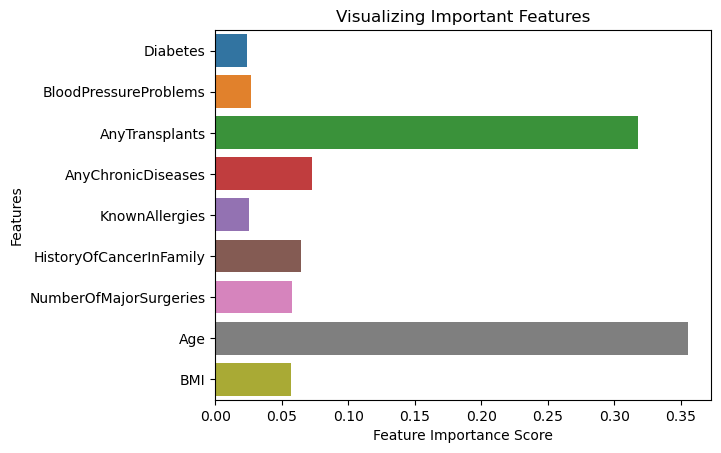

In [45]:
feature_imp1 = model.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [46]:
scores = cross_val_score(model, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)

In [47]:
scores = np.sqrt(-scores)

In [48]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [49]:
display_scores(scores)

Scores: [3816.08810533 2338.84974138 1686.27003749 3395.88239282 2625.49815687
 3994.44677539 2570.45565719 2787.29057462 2186.37195721 3532.55166819]
Mean: 2893.370506648181
Standard deviation: 719.4832720738407


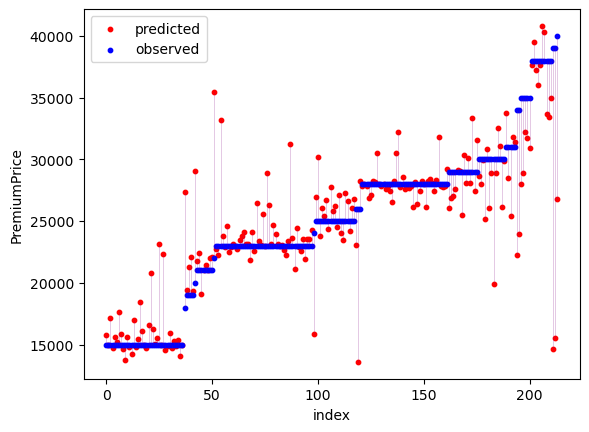

In [50]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

# Cluster wise model fitting

In [51]:
dq = pd.read_csv("data.csv")

In [52]:
dq.drop(["BMI", "BMI_cat"], axis=1, inplace=True)

In [53]:
cluster1 = dq[dq.cluster == 1]
cluster2 = dq[dq.cluster == 2]
cluster3 = dq[dq.cluster == 3]

## cluster1

3555.052248733916


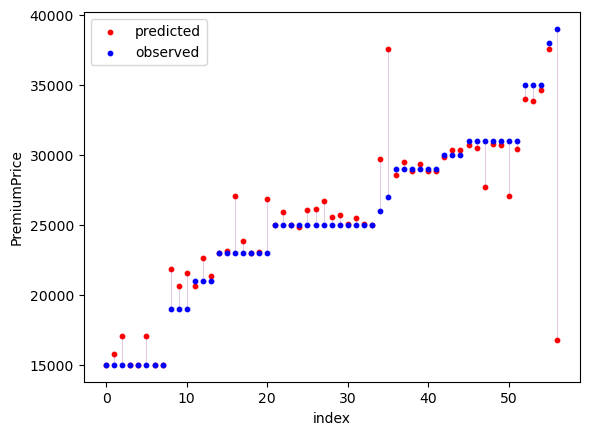

In [54]:
X_c1 = cluster1.drop("PremiumPrice", axis=1)
y_c1 = cluster1.PremiumPrice
X_c1_train, X_c1_test, y_c1_train, y_c1_test = train_test_split(X_c1, y_c1, test_size=0.2, random_state=42)

forest_reg = RandomForestRegressor()

forest_reg.fit(X_c1_train, y_c1_train)

pred = forest_reg.predict(X_c1_test)

print(np.sqrt(mean_squared_error(y_c1_test, pred)))

temp = pd.DataFrame({'Observed':y_c1_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

### cv

In [55]:
scores = cross_val_score(forest_reg, X_c1_train, y_c1_train, scoring="neg_mean_squared_error", cv=10)

scores = np.sqrt(-scores)

display_scores(scores)

Scores: [3275.33602657 2997.86808307 2206.3101205  1429.28531852 2959.7877421
 3294.17008088 1317.91831904 1203.91571278 2348.21208582 2562.99895364]
Mean: 2359.5802442912523
Standard deviation: 763.5964957356995


## cluster2

4933.901213858949


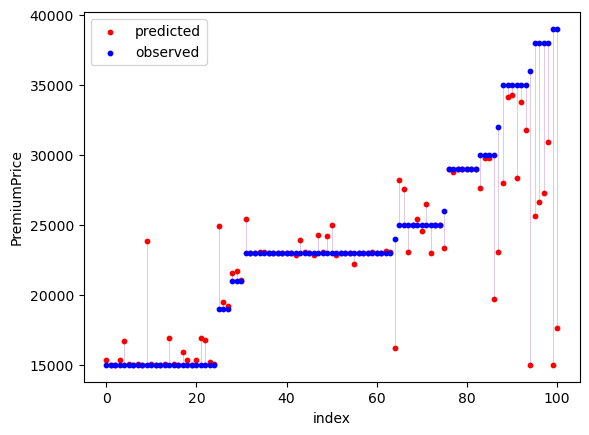

In [56]:
X_c2 = cluster2.drop("PremiumPrice", axis=1)
y_c2 = cluster2.PremiumPrice
X_c2_train, X_c2_test, y_c2_train, y_c2_test = train_test_split(X_c2, y_c2, test_size=0.2, random_state=42)

forest_reg = RandomForestRegressor()

forest_reg.fit(X_c2_train, y_c2_train)

pred = forest_reg.predict(X_c2_test)

print(np.sqrt(mean_squared_error(y_c2_test, pred)))

temp = pd.DataFrame({'Observed':y_c2_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

### cv

In [57]:
scores = cross_val_score(forest_reg, X_c2_train, y_c2_train, scoring="neg_mean_squared_error", cv=10)

scores = np.sqrt(-scores)

display_scores(scores)

Scores: [2448.08956127 3896.14039788 1688.23650594 1961.85180378 3844.11628336
 1132.29965115 3488.47280339 3296.39575901 3524.53791298 2326.68326164]
Mean: 2760.682394040363
Standard deviation: 926.7797576746954


## cluster3

1625.261517418043


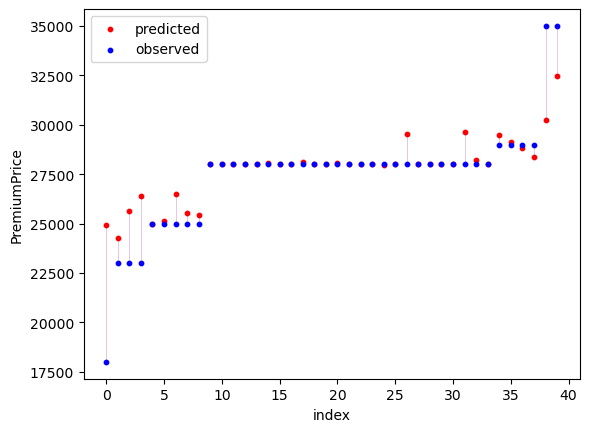

In [58]:
X_c3 = cluster3.drop("PremiumPrice", axis=1)
y_c3 = cluster3.PremiumPrice
X_c3_train, X_c3_test, y_c3_train, y_c3_test = train_test_split(X_c3, y_c3, test_size=0.2, random_state=42)

forest_reg = RandomForestRegressor()

forest_reg.fit(X_c3_train, y_c3_train)

pred = forest_reg.predict(X_c3_test)

print(np.sqrt(mean_squared_error(y_c3_test, pred)))

temp = pd.DataFrame({'Observed':y_c3_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

### cv

In [59]:
scores = cross_val_score(forest_reg, X_c3_train, y_c3_train, scoring="neg_mean_squared_error", cv=10)

scores = np.sqrt(-scores)

display_scores(scores)

Scores: [ 251.80597689 2577.20657884 1565.76059792 1440.27775099 2664.2764027
 1890.43315142 1913.96675781 1495.61024335 3244.223713    993.56051653]
Mean: 1803.7121689452156
Standard deviation: 823.5293173888508


# Adding cluster label

In [71]:
dp = upsample().fit_transform(dq.copy())

In [97]:
X = dp.drop("PremiumPrice", axis=1)
y = dp.PremiumPrice

In [98]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [99]:
X_train = pipe.fit_transform(x_train.copy())
X_test = pipe.fit_transform(x_test.copy())

In [107]:
forest_reg = RandomForestRegressor(random_state=42)

In [108]:
forest_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [109]:
pred = forest_reg.predict(X_test)

In [110]:
np.sqrt(mean_squared_error(y_test, pred))

3758.7159768187494

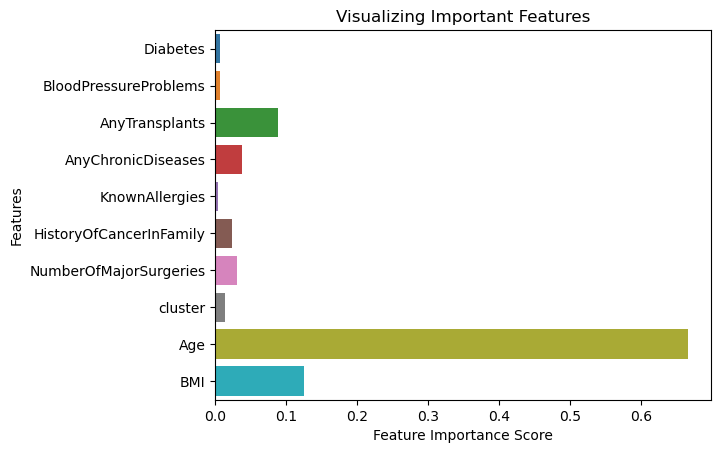

In [111]:
feature_imp1 = forest_reg.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

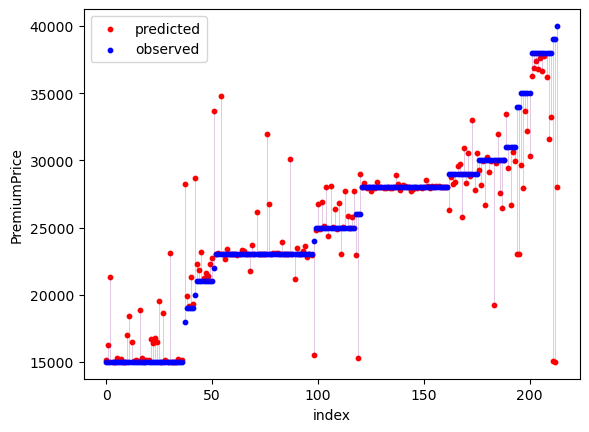

In [112]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

## cross validation

In [113]:
scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)

scores = np.sqrt(-scores)

display_scores(scores)

Scores: [3283.2791677  1877.8900208  1864.35349478 3037.34048294 2272.41752223
 3814.10341807 2867.90556904 2518.98999368 1955.92463466 3756.06568257]
Mean: 2724.8269986461323
Standard deviation: 705.4043003143042
